# Example: North American pumpkin prices

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime

## Visualize and clean data in preparation for ML

In [2]:
pumpkins = pd.read_csv('data/US-pumpkins.csv')
pumpkins.head()

,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,Mostly Low,...,Unit of Sale,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode,Unnamed: 24,Unnamed: 25
0,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,4/29/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
1,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,5/6/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
2,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
3,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
4,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,11/5/16,90.0,100.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN


In [4]:
pumpkins.shape

(1757, 26)

In [5]:
pumpkins["Package"]

0        24 inch bins
1        24 inch bins
2        24 inch bins
3        24 inch bins
4        24 inch bins
            ...      
1752    22 lb cartons
1753     36 inch bins
1754     36 inch bins
1755     36 inch bins
1756     36 inch bins
Name: Package, Length: 1757, dtype: object

In [6]:
pumpkins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1757 entries, 0 to 1756
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   City Name        1757 non-null   object 
 1   Type             45 non-null     object 
 2   Package          1757 non-null   object 
 3   Variety          1752 non-null   object 
 4   Sub Variety      296 non-null    object 
 5   Grade            0 non-null      float64
 6   Date             1757 non-null   object 
 7   Low Price        1757 non-null   float64
 8   High Price       1757 non-null   float64
 9   Mostly Low       1654 non-null   float64
 10  Mostly High      1654 non-null   float64
 11  Origin           1754 non-null   object 
 12  Origin District  131 non-null    object 
 13  Item Size        1478 non-null   object 
 14  Color            1141 non-null   object 
 15  Environment      0 non-null      float64
 16  Unit of Sale     162 non-null    object 
 17  Quality       

In [9]:
pumpkins["Date"] = pd.to_datetime(pumpkins["Date"])

In [10]:
pumpkins["Month"] = pumpkins["Date"].dt.month

In [11]:
pumpkins["DayOfYear"] = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)

In [12]:
pumpkins.isnull().sum()

City Name             0
Type               1712
Package               0
Variety               5
Sub Variety        1461
Grade              1757
Date                  0
Low Price             0
High Price            0
Mostly Low          103
Mostly High         103
Origin                3
Origin District    1626
Item Size           279
Color               616
Environment        1757
Unit of Sale       1595
Quality            1757
Condition          1757
Appearance         1757
Storage            1757
Crop               1757
Repack                0
Trans Mode         1757
Unnamed: 24        1757
Unnamed: 25        1654
Month                 0
DayOfYear             0
dtype: int64

In [13]:
new_columns = ['Package', 'Variety', 'City Name', 'Month', 'Low Price', 'High Price', 'DayOfYear']
pumpkins = pumpkins.drop([c for c in pumpkins.columns if c not in new_columns], axis=1)
pumpkins.head()

,City Name,Package,Variety,Low Price,High Price,Month,DayOfYear
0,BALTIMORE,24 inch bins,NaN,270.0,280.0,4,118
1,BALTIMORE,24 inch bins,NaN,270.0,280.0,5,125
2,BALTIMORE,24 inch bins,HOWDEN TYPE,160.0,160.0,9,267
3,BALTIMORE,24 inch bins,HOWDEN TYPE,160.0,160.0,9,267
4,BALTIMORE,24 inch bins,HOWDEN TYPE,90.0,100.0,11,309


In [15]:
pumpkins['Price'] = (pumpkins['Low Price'] + pumpkins['High Price']) / 2
pumpkins.head()

,City Name,Package,Variety,Low Price,High Price,Month,DayOfYear,Price
0,BALTIMORE,24 inch bins,NaN,270.0,280.0,4,118,275.0
1,BALTIMORE,24 inch bins,NaN,270.0,280.0,5,125,275.0
2,BALTIMORE,24 inch bins,HOWDEN TYPE,160.0,160.0,9,267,160.0
3,BALTIMORE,24 inch bins,HOWDEN TYPE,160.0,160.0,9,267,160.0
4,BALTIMORE,24 inch bins,HOWDEN TYPE,90.0,100.0,11,309,95.0


In [16]:
pumpkins["Package"].unique()

array(['24 inch bins', '36 inch bins', '50 lb sacks',
       '1 1/9 bushel cartons', '1/2 bushel cartons',
       '1 1/9 bushel crates', 'bushel cartons', 'bins', '35 lb cartons',
       'each', '20 lb cartons', '50 lb cartons', '40 lb cartons',
       'bushel baskets', '22 lb cartons'], dtype=object)

In [17]:
new_pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

In [18]:
new_pumpkins.shape

(415, 8)

In [21]:
new_pumpkins["Package"].unique()

array(['1 1/9 bushel cartons', '1/2 bushel cartons',
       '1 1/9 bushel crates', 'bushel cartons', 'bushel baskets'],
      dtype=object)

In [22]:
new_pumpkins.head()

,City Name,Package,Variety,Low Price,High Price,Month,DayOfYear,Price
70,BALTIMORE,1 1/9 bushel cartons,PIE TYPE,15.0,15.0,9,267,15.0
71,BALTIMORE,1 1/9 bushel cartons,PIE TYPE,18.0,18.0,9,267,18.0
72,BALTIMORE,1 1/9 bushel cartons,PIE TYPE,18.0,18.0,10,274,18.0
73,BALTIMORE,1 1/9 bushel cartons,PIE TYPE,17.0,17.0,10,274,17.0
74,BALTIMORE,1 1/9 bushel cartons,PIE TYPE,15.0,15.0,10,281,15.0


In [23]:
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = new_pumpkins['Price']/(1 + 1/9)
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = new_pumpkins['Price']/(1/2)

In [24]:
new_pumpkins.head()

,City Name,Package,Variety,Low Price,High Price,Month,DayOfYear,Price
70,BALTIMORE,1 1/9 bushel cartons,PIE TYPE,15.0,15.0,9,267,13.5
71,BALTIMORE,1 1/9 bushel cartons,PIE TYPE,18.0,18.0,9,267,16.2
72,BALTIMORE,1 1/9 bushel cartons,PIE TYPE,18.0,18.0,10,274,16.2
73,BALTIMORE,1 1/9 bushel cartons,PIE TYPE,17.0,17.0,10,274,15.3
74,BALTIMORE,1 1/9 bushel cartons,PIE TYPE,15.0,15.0,10,281,13.5


**Visualization Strategies**

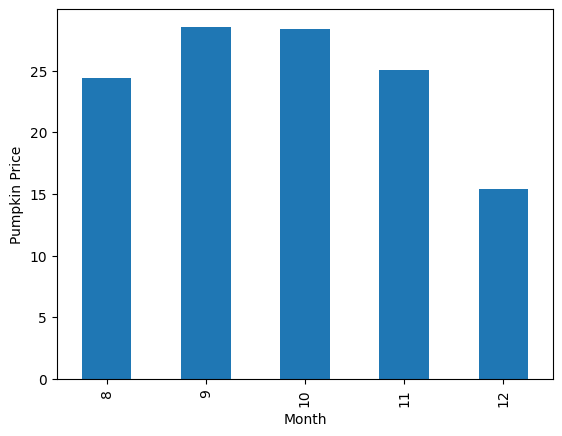

In [25]:
new_pumpkins.groupby(['Month'])['Price'].mean().plot(kind='bar')
plt.ylabel("Pumpkin Price")
plt.show()

**Looking for Correlation**

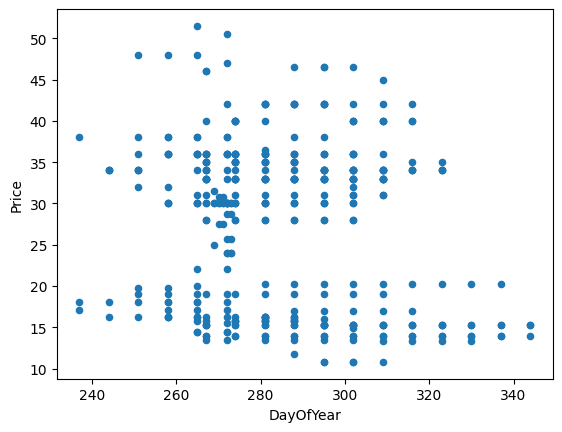

In [26]:
new_pumpkins.plot.scatter('DayOfYear','Price')
plt.show()

In [27]:
print(new_pumpkins['Month'].corr(new_pumpkins['Price']))
print(new_pumpkins['DayOfYear'].corr(new_pumpkins['Price']))

-0.14912913634278593
-0.1669009250593447


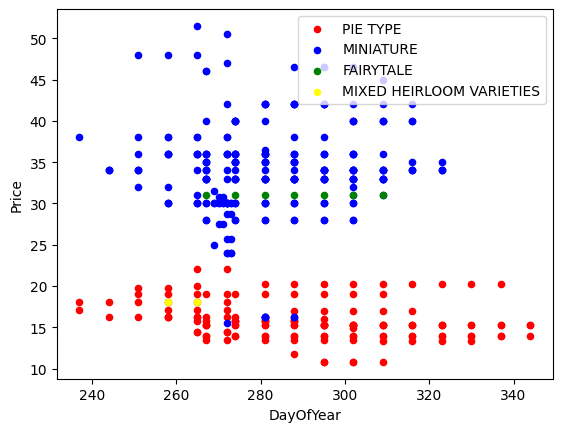

In [28]:
ax=None
colors = ['red','blue','green','yellow']
for i,var in enumerate(new_pumpkins['Variety'].unique()):
    ax = new_pumpkins[new_pumpkins['Variety']==var].plot.scatter('DayOfYear','Price',ax=ax,c=colors[i],label=var)

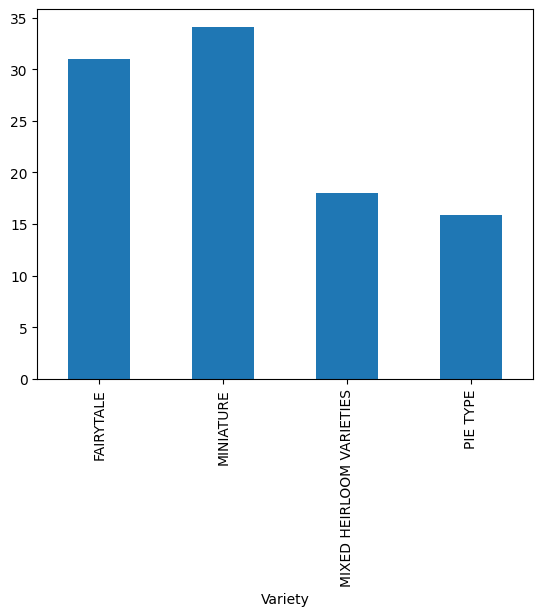

In [29]:
new_pumpkins.groupby('Variety')['Price'].mean().plot(kind='bar')
plt.show()

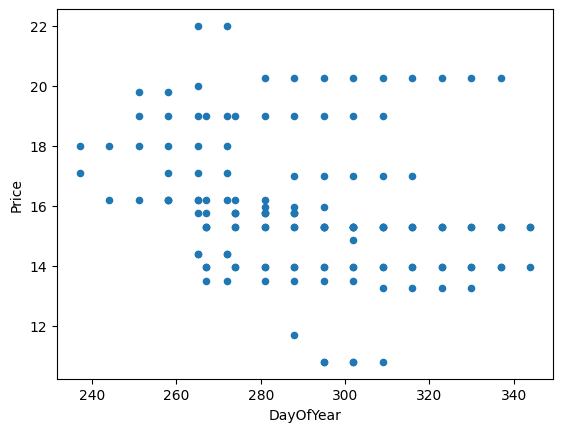

In [30]:
pie_pumpkins = new_pumpkins[new_pumpkins['Variety']=='PIE TYPE'].copy()
pie_pumpkins.plot.scatter('DayOfYear','Price') 
plt.show()

In [31]:
print(pie_pumpkins['DayOfYear'].corr(pie_pumpkins['Price']))

-0.266785596914419


----

## Build a regression model using Scikit-learn

In [32]:
pie_pumpkins.dropna(inplace=True)
pie_pumpkins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 70 to 1630
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City Name   144 non-null    object 
 1   Package     144 non-null    object 
 2   Variety     144 non-null    object 
 3   Low Price   144 non-null    float64
 4   High Price  144 non-null    float64
 5   Month       144 non-null    int32  
 6   DayOfYear   144 non-null    int64  
 7   Price       144 non-null    float64
dtypes: float64(3), int32(1), int64(1), object(3)
memory usage: 9.6+ KB


**Simple Linear Regression**

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [34]:
X = pie_pumpkins['DayOfYear'].to_numpy().reshape(-1,1)
y = pie_pumpkins['Price']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [36]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

LinearRegression()

In [40]:
from sklearn.metrics import mean_squared_error

pred = lin_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Sqrt. Mean error: {rmse:3.3}')

Sqrt. Mean error: 2.76


In [41]:
score = lin_reg.score(X_train,y_train)
print('Model determination: ', score)

Model determination:  0.04499342423558461


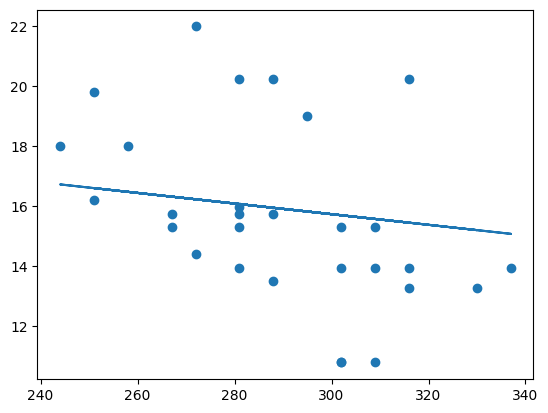

In [42]:
plt.scatter(X_test,y_test)
plt.plot(X_test,pred)
plt.show()

**Polynomial Regression**

In [43]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2, include_bias=False), LinearRegression())

pipeline.fit(X_train,y_train)

pred = pipeline.predict(X_test)

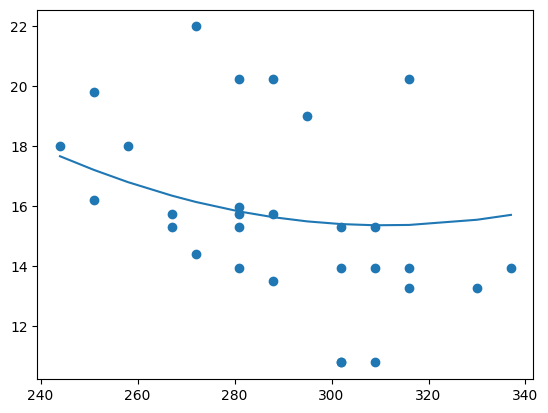

In [44]:
plt.scatter(X_test,y_test)
plt.plot(sorted(X_test),pipeline.predict(sorted(X_test)))
plt.show()

In [45]:
rmse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Sqrt. Mean error: {rmse:3.3}')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

Sqrt. Mean error: 2.73
Model determination:  0.07486289050738915


**Categorical Features**

In [46]:
pd.get_dummies(new_pumpkins['Variety'])

,FAIRYTALE,MINIATURE,MIXED HEIRLOOM VARIETIES,PIE TYPE
70,False,False,False,True
71,False,False,False,True
72,False,False,False,True
73,False,False,False,True
74,False,False,False,True
...,...,...,...,...
1738,False,True,False,False
1739,False,True,False,False
1740,False,True,False,False
1741,False,True,False,False


**Linear Regression on Variety**

In [47]:
X = pd.get_dummies(new_pumpkins['Variety'])
y = new_pumpkins['Price']

In [49]:
def run_linear_regression(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    lin_reg = LinearRegression()
    lin_reg.fit(X_train,y_train)

    pred = lin_reg.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test,pred))
    print(f'Sqrt. Mean error: {rmse:3.3}')

    score = lin_reg.score(X_train,y_train)
    print('Model determination: ', score)

run_linear_regression(X,y)

Sqrt. Mean error: 5.26
Model determination:  0.7757064548947359


In [51]:
X = pd.get_dummies(new_pumpkins['Variety']) \
        .join(new_pumpkins['Month']) \
        .join(pd.get_dummies(new_pumpkins['City Name'])) \
        .join(pd.get_dummies(new_pumpkins['Package']))

y = new_pumpkins['Price']

run_linear_regression(X,y)

Sqrt. Mean error: 2.84
Model determination:  0.940955922897385


**Polynomial Regression**

In [52]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipeline.fit(X_train,y_train)

pred = pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Sqrt. Mean error: {rmse:3.3}')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

Sqrt. Mean error: 2.36
Model determination:  0.9623067544009121


---

## Logistic regression to predict categories

**Tidy the data**

In [53]:
pumpkins = pd.read_csv('./data/US-pumpkins.csv')

In [54]:
from sklearn.preprocessing import LabelEncoder

new_columns = ['Color','Origin','Item Size','Variety','City Name','Package']
new_pumpkins = pumpkins.drop([c for c in pumpkins.columns if c not in new_columns], axis=1)
new_pumpkins.dropna(inplace=True)
new_pumpkins = new_pumpkins.apply(LabelEncoder().fit_transform)

new_pumpkins.head()

,City Name,Package,Variety,Origin,Item Size,Color
2,1,3,4,3,3,0
3,1,3,4,17,3,0
4,1,3,4,5,2,0
5,1,3,4,5,2,0
6,1,4,4,5,3,0


In [55]:
new_pumpkins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 991 entries, 2 to 1698
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   City Name  991 non-null    int32
 1   Package    991 non-null    int32
 2   Variety    991 non-null    int32
 3   Origin     991 non-null    int32
 4   Item Size  991 non-null    int32
 5   Color      991 non-null    int32
dtypes: int32(6)
memory usage: 31.0 KB


**Build your model**

In [56]:
from sklearn.model_selection import train_test_split

Selected_features = ['Origin','Item Size','Variety','City Name','Package']

X = new_pumpkins[Selected_features]
y = new_pumpkins['Color']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report 
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print(classification_report(y_test, predictions))
print('Predicted labels: ', predictions)
print('Accuracy: ', accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.83      0.98      0.90       166
           1       0.00      0.00      0.00        33

    accuracy                           0.81       199
   macro avg       0.42      0.49      0.45       199
weighted avg       0.69      0.81      0.75       199

Predicted labels:  [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
Accuracy:  0.8140703517587939


In [58]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, predictions)

array([[162,   4],
       [ 33,   0]], dtype=int64)